In [1]:
import pandas as pd
import numpy as np

full_pumpkins = pd.read_csv('US-pumpkins.csv')

In [3]:
columns_to_select = ['City Name','Package','Variety', 'Origin','Item Size', 'Color']
pumpkins = full_pumpkins.loc[:, columns_to_select]

pumpkins.dropna(inplace=True)

In [4]:
pumpkins.info

<bound method DataFrame.info of       City Name       Package            Variety    Origin Item Size   Color
2     BALTIMORE  24 inch bins        HOWDEN TYPE  DELAWARE       med  ORANGE
3     BALTIMORE  24 inch bins        HOWDEN TYPE  VIRGINIA       med  ORANGE
4     BALTIMORE  24 inch bins        HOWDEN TYPE  MARYLAND       lge  ORANGE
5     BALTIMORE  24 inch bins        HOWDEN TYPE  MARYLAND       lge  ORANGE
6     BALTIMORE  36 inch bins        HOWDEN TYPE  MARYLAND       med  ORANGE
...         ...           ...                ...       ...       ...     ...
1694  ST. LOUIS  24 inch bins  HOWDEN WHITE TYPE  ILLINOIS      xlge   WHITE
1695  ST. LOUIS  24 inch bins  HOWDEN WHITE TYPE  ILLINOIS      xlge   WHITE
1696  ST. LOUIS  24 inch bins  HOWDEN WHITE TYPE  ILLINOIS      xlge   WHITE
1697  ST. LOUIS  24 inch bins  HOWDEN WHITE TYPE  ILLINOIS      xlge   WHITE
1698  ST. LOUIS  24 inch bins  HOWDEN WHITE TYPE  ILLINOIS      xlge   WHITE

[991 rows x 6 columns]>

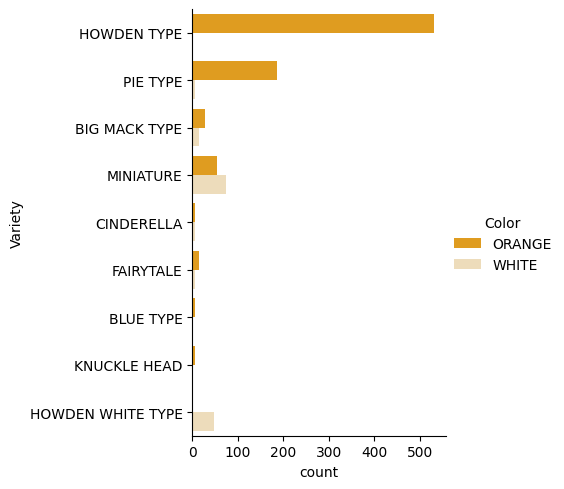

In [7]:
import seaborn as sns

palette = {
    'ORANGE': 'orange',
    'WHITE': 'wheat',
}

sns.catplot(
    data = pumpkins,
    y = 'Variety',
    hue = 'Color', 
    kind = 'count',
    palette = palette,
)

In [17]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

In [18]:
item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Item Size']
ordinal_encoder = OrdinalEncoder(categories=item_size_categories)

In [19]:
categorical_features = ['City Name', 'Package', 'Variety', 'Origin']
categorical_encoder = OneHotEncoder(sparse_output=False)

In [20]:
ct = ColumnTransformer(transformers=[
        ('ord', ordinal_encoder, ordinal_features),
        ('cat', categorical_encoder, categorical_features)
    ])

ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(pumpkins)

In [22]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(pumpkins['Color'])
encoded_pumpkins = encoded_features.assign(Color=encoded_label)

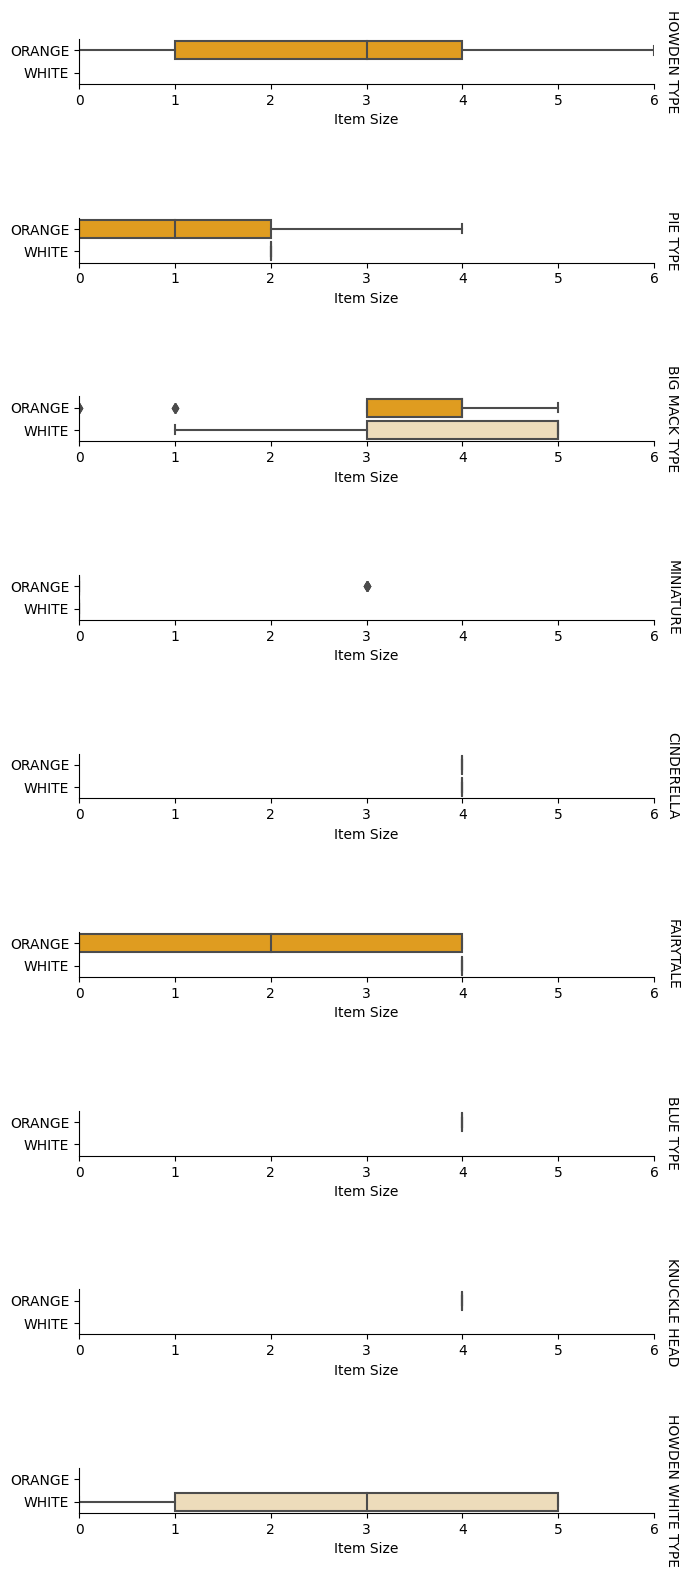

In [27]:
palette = {
    'ORANGE': 'orange',
    'WHITE': 'wheat',
}

pumpkins['Item Size'] = encoded_pumpkins['ord__Item Size']

g = sns.catplot(
    data=pumpkins,
    x="Item Size", y="Color", row='Variety',
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.8, aspect=4, palette=palette,
)

g.set(xlabel="Item Size", ylabel="").set(xlim=(0,6))
g.set_titles(row_template="{row_name}")

<Axes: xlabel='Color', ylabel='ord__Item Size'>

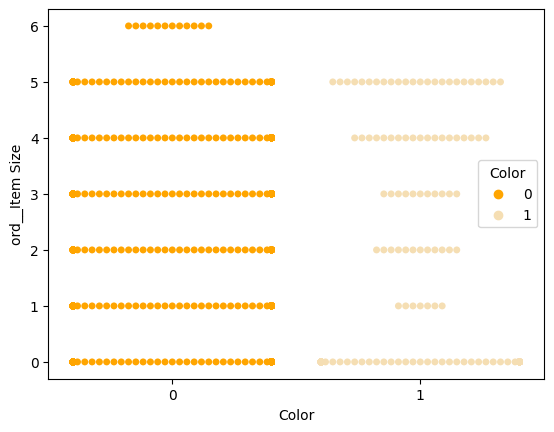

In [29]:
palette = {
    0: 'orange',
    1: 'wheat'
}
sns.swarmplot(x="Color", y="ord__Item Size", hue="Color", data=encoded_pumpkins, palette=palette)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = encoded_pumpkins[encoded_pumpkins.columns.difference(['Color'])]
y = encoded_pumpkins['Color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
from sklearn.metrics import f1_score, classification_report 
from sklearn.linear_model import LogisticRegression

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       166
           1       0.85      0.67      0.75        33

    accuracy                           0.92       199
   macro avg       0.89      0.82      0.85       199
weighted avg       0.92      0.92      0.92       199

Predicted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
F1-score:  0.7457627118644068


In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[162,   4],
       [ 11,  22]], dtype=int64)

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

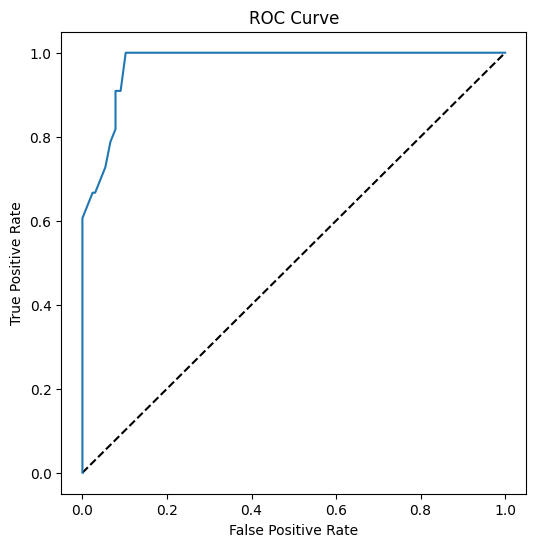

In [37]:
y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [38]:
# Calculate AUC score
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.9749908725812341
